In [1]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [2]:
os.getcwd()

'/home/evlasova/tcr-covid-classifier'

# Training separate α/β classifiers

In [3]:
desc_for_projects = pd.read_csv('data/desc_fmba_new_split.csv').drop(columns=['Unnamed: 0'])[['run', 'folder']]
desc_for_projects

,run,folder
0,020000010808_S3_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
1,020000110808_S14_L001.clonotypes.TRB.txt,NovaSeq14
2,020000190808_S27_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
3,020000200808_S181_L002.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
4,020000280808_S59_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
...,...,...
951,780008510808_S152_L002.clonotypes.TRB.txt,NovaSeq34
952,780008550808_S150_L002.clonotypes.TRB.txt,NovaSeq34
953,910000140808_S123_L002.clonotypes.TRB.txt,NovaSeq24
954,910000320808_S121_L002.clonotypes.TRB.txt,NovaSeq24


In [4]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=True, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)

In [5]:
data_beta

,CANSLGGSYEQYF,CASARGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASGPPYEQYF,CASMRGYEQYF,CASNLGGSYEQYF,CASRDAYEQYF,CASRGGPYEQYF,...,DRB1*15,DRB1*13,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16,covid,is_test_run
0,-0.470897,-0.491612,-0.730978,-0.554563,14.708203,6.507599,-0.479077,-0.494175,-0.510176,-0.547414,...,False,False,False,False,False,False,False,True,1,False
1,0.773726,-0.491612,-0.730978,-0.554563,0.948571,-0.327308,-0.479077,-0.494175,1.739151,-0.547414,...,True,False,False,False,False,False,False,False,1,False
2,-0.470897,-0.491612,0.160845,-0.554563,-0.302305,-0.327308,-0.479077,-0.494175,-0.510176,-0.547414,...,False,False,True,False,False,False,False,False,0,False
3,-0.470897,2.562057,-0.730978,-0.554563,3.164432,4.408339,2.560617,-0.494175,2.606769,-0.547414,...,False,True,False,False,False,False,False,False,1,False
4,-0.470897,-0.491612,-0.730978,-0.554563,-0.302305,-0.327308,-0.479077,-0.494175,-0.510176,-0.547414,...,False,False,False,False,False,False,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,-0.470897,-0.491612,-0.730978,-0.554563,-0.302305,-0.327308,-0.479077,-0.494175,-0.510176,-0.547414,...,False,False,False,False,False,False,False,False,0,False
952,1.984502,1.682088,-0.730978,1.443424,-0.302305,-0.327308,1.684675,1.647576,3.927307,1.558292,...,True,True,False,False,False,False,False,False,0,False
953,-0.470897,7.070337,-0.730978,-0.554563,-0.302305,-0.327308,7.048266,-0.494175,-0.510176,-0.547414,...,True,False,True,False,False,False,False,False,0,False
954,-0.470897,-0.491612,-0.730978,-0.554563,-0.302305,-0.327308,-0.479077,-0.494175,-0.510176,-0.547414,...,False,False,False,False,False,False,False,False,0,False


In [6]:
X_train, y_train, X_test, y_test = split_data(data=data_beta, y_column='covid', by='is_test_run')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 10, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.73

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 50, 'model__weights': 'distance'}
Test f1-score for the best model 0.69

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 1e-05, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_sta

In [8]:
data_alpha = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data(data=data_alpha, y_column='covid', by='is_test_run')

best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, 
                                  X_test_alpha, y_test_alpha, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 10, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.73

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 125, 'model__random_state': 42}
Test f1-score for the best model 0.71

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.68

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.66

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state'

# Training joint αβ classifier

In [9]:
data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=False,
                     make_all_features_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid')
print('alpha ready')
data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=True, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid')
data_joint = pd.concat([data_beta_for_joint[[x for x in data_beta_for_joint.columns if x.startswith('CAS')]], data_alpha_for_joint], axis=1)


X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data(data=data_joint, y_column='covid')

best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

alpha ready
Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'linear', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.75

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.68

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.60

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model_

# Training classifiers based on metaclones

In [10]:
data_beta_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRB_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'project'])

data_alpha_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRA_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'project'])

data_beta_meta = data_beta_meta.rename(columns={f'cluster_{x}': f'b_cluster_{x}' for x in range(len(data_beta_meta.columns))})
data_alpha_meta = data_alpha_meta.rename(columns={f'cluster_{x}': f'a_cluster_{x}' for x in range(len(data_beta_meta.columns))})
data_joint_meta = pd.concat([data_beta_meta[[x for x in data_beta_meta.columns if x.startswith('b')]], data_alpha_meta], axis=1)

In [11]:
X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m = split_data(data=data_beta_meta.drop(columns=['project']), 
                                                       y_column='covid') 
X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m = split_data(data=data_alpha_meta.drop(columns=['project']), 
                                                       y_column='covid') 
X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m = split_data(data=data_joint_meta.drop(columns=['project']), 
                                                       y_column='covid')

In [12]:
best_clfs_beta_m = evaluate_models(X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_alpha_m = evaluate_models(X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_joint_m = evaluate_models(X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 50, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.68

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 100, 'model__random_state': 42}
Test f1-score for the best model 0.71

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.66

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_sta

In [13]:
best_clfs_joint_m = (best_clfs_joint_m[0], best_clfs_joint_m[1], 'svm')

In [14]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint,
     'beta_meta': best_clfs_beta_m,
     'alpha_meta': best_clfs_alpha_m,
     'joint_meta': best_clfs_joint_m,
}
X_test_data={
     'beta': X_test,
     'alpha': X_test_alpha,
     'joint': X_test_joint,
     'beta_meta': X_test_beta_m,
     'alpha_meta': X_test_alpha_m,
     'joint_meta': X_test_joint_m,
}
y_test_data={
     'beta': y_test,
     'alpha': y_test_alpha,
     'joint': y_test_joint,
     'beta_meta': y_test_beta_m,
     'alpha_meta': y_test_alpha_m,
     'joint_meta': y_test_joint_m,
}
X_train_data={
     'beta': X_train,
     'alpha': X_train_alpha,
     'joint': X_train_joint,
     'beta_meta': X_train_beta_m,
     'alpha_meta': X_train_alpha_m,
     'joint_meta': X_train_joint_m,
}
y_train_data={
     'beta': y_train,
     'alpha': y_train_alpha,
     'joint': y_train_joint,
     'beta_meta': y_train_beta_m,
     'alpha_meta': y_train_alpha_m,
     'joint_meta': y_train_joint_m,
}

In [15]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['beta','alpha','joint','beta_meta','alpha_meta','joint_meta']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

In [16]:
comparison_df

,model,f1,data_type
0,svm,0.734375,beta
1,ab,0.691729,beta
2,knn,0.692913,beta
3,rfc,0.627219,beta
4,mlpclassifier,0.728682,beta
5,xgboost,0.657343,beta
6,svm,0.732143,alpha
7,ab,0.706897,alpha
8,knn,0.677165,alpha
9,rfc,0.658228,alpha


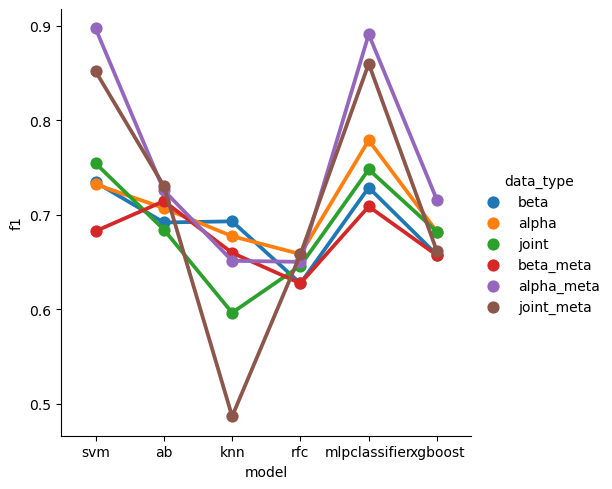

In [17]:
fig, ax = plt.subplots()
sns.catplot(data=comparison_df, x="model", y="f1", hue="data_type", kind="point", ax=ax)
plt.close(1)

<AxesSubplot:xlabel='model', ylabel='f1'>

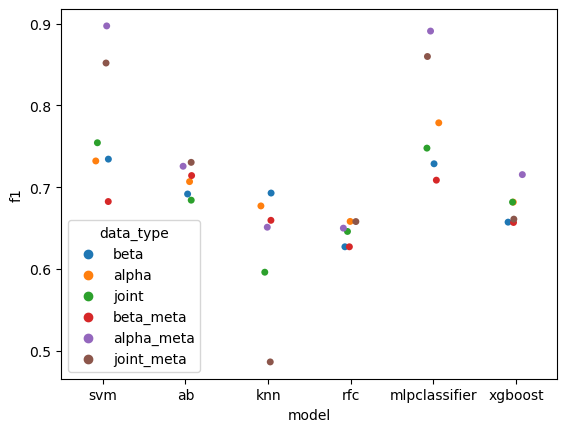

In [18]:
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type",)

In [19]:
all_clfs['joint']

({'svm': Pipeline(steps=[('model',
                   SVC(C=1, kernel='linear', probability=True, random_state=42))]),
  'ab': Pipeline(steps=[('model',
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                      n_estimators=150, random_state=42))]),
  'knn': Pipeline(steps=[('model',
                   KNeighborsClassifier(leaf_size=1, n_neighbors=10,
                                        weights='distance'))]),
  'rfc': Pipeline(steps=[('model',
                   RandomForestClassifier(max_depth=3, min_samples_leaf=10,
                                          n_estimators=200, n_jobs=-1,
                                          random_state=42))]),
  'mlpclassifier': Pipeline(steps=[('model',
                   MLPClassifier(alpha=0.001,
                                 hidden_layer_sizes=(100, 50, 25, 10),
                                 max_iter=1000, random_state=42))]),
  'xgboost': Pipeline(steps=[('model

# Making metrics dataframe

In [20]:
clf_name = []
clf_type = []
f1 = []
precision = []
recall = []
for key, clfs in all_clfs.items():
    clf_name.append(key)
    clf_type.append(clfs[2])
    best_clf = clfs[0]['svm']
    clf_predictions = best_clf.predict(X_test_data[key])
    f1.append(f1_score(y_test_data[key], clf_predictions))
    precision.append(precision_score(y_test_data[key], clf_predictions))
    recall.append(recall_score(y_test_data[key], clf_predictions))

In [21]:
plotting_df = pd.DataFrame({
    'classifier': clf_name, 
    'best_classifier_predictor': clf_type,
    'f1_score': f1,
    'precision_score': precision,
    'recall_score': recall
})

In [22]:
plotting_df

,classifier,best_classifier_predictor,f1_score,precision_score,recall_score
0,beta,svm,0.734375,0.626667,0.886792
1,alpha,mlpclassifier,0.732143,0.694915,0.773585
2,joint,svm,0.754386,0.704918,0.811321
3,beta_meta,ab,0.682540,0.589041,0.811321
4,alpha_meta,svm,0.897196,0.888889,0.905660
5,joint_meta,svm,0.851852,0.836364,0.867925


In [23]:
plotting_df = plotting_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

# Preparing data for proba comparison

In [24]:
beta_predictions = all_clfs['beta'][0]['svm'].predict_proba(X_test_data['beta'])[::,1]
alpha_predictions = all_clfs['alpha'][0]['svm'].predict_proba(X_test_data['alpha'])[::,1]
beta_meta_predictions = all_clfs['beta_meta'][0]['svm'].predict_proba(X_test_data['beta_meta'])[::,1]
alpha_meta_predictions = all_clfs['alpha_meta'][0]['svm'].predict_proba(X_test_data['alpha_meta'])[::,1]
joint_predictions = all_clfs['joint'][0]['svm'].predict_proba(X_test_data['joint'])[::,1]
joint_meta_predictions = all_clfs['joint_meta'][0]['svm'].predict_proba(X_test_data['joint_meta'])[::,1]

proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({
    'beta_proba': beta_predictions,
    'alpha_proba': alpha_predictions,
    'beta_meta_proba': beta_meta_predictions,
    'alpha_meta_proba': alpha_meta_predictions,
    'joint_proba': joint_predictions,
    'joint_meta_proba': joint_meta_predictions,
    'covid': proba_labels
})

In [25]:
probability_df

,beta_proba,alpha_proba,beta_meta_proba,alpha_meta_proba,joint_proba,joint_meta_proba,covid
420,0.955145,0.990248,0.948900,0.907871,0.992855,0.997154,covid
421,0.664494,0.016215,0.825516,0.028856,0.075619,0.025601,covid
422,0.917816,0.336625,0.943423,0.824524,0.594596,0.859082,covid
423,0.945230,0.812957,0.849121,0.914180,0.849592,0.768909,covid
424,0.554892,0.806364,0.476790,0.686187,0.620932,0.266618,covid
...,...,...,...,...,...,...,...
531,0.758220,0.117042,0.916488,0.044395,0.306636,0.058668,healthy
532,0.917089,0.685090,0.676627,0.379538,0.693800,0.598015,healthy
533,0.277134,0.398357,0.148330,0.082931,0.265775,0.006724,healthy
534,0.530353,0.658940,0.875218,0.277119,0.645904,0.814892,healthy


# One folder out CV

In [26]:
data_joint_meta

,b_cluster_0,b_cluster_1,b_cluster_2,b_cluster_3,b_cluster_4,b_cluster_5,b_cluster_6,b_cluster_7,b_cluster_8,b_cluster_9,...,DRB1*13,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16,covid,is_test_run,project
0,-1.022938,-0.056911,-0.847810,14.708203,6.507599,-0.547414,1.701072,-0.637891,0.462278,-0.750347,...,False,False,False,False,False,False,True,1,False,2020/10_FMBA_NovaSeq5
1,1.232259,1.535196,0.017118,0.948571,-0.327308,-0.547414,-0.357235,0.727612,1.330931,1.238724,...,False,False,False,False,False,False,False,1,False,2020/10_FMBA_NovaSeq5
2,-0.272199,0.500341,0.246309,-0.302305,-0.327308,-0.547414,0.428092,-0.637891,0.789359,-0.750347,...,False,True,False,False,False,False,False,0,False,2020/10_FMBA_NovaSeq5
3,0.107456,0.425753,-1.214960,3.164432,4.408339,-0.547414,1.044833,3.146529,2.177154,-0.750347,...,True,False,False,False,False,False,False,1,False,2020/10_FMBA_NovaSeq5
4,0.354244,0.400520,0.688272,-0.302305,-0.327308,-0.547414,1.487514,-0.637891,-0.278751,-0.180525,...,False,False,False,False,False,False,True,1,False,2020/10_FMBA_NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,-1.177202,-0.970341,-1.671550,-0.302305,-0.327308,-0.547414,-0.299985,-0.637891,-0.645573,-0.750347,...,False,False,False,False,False,False,False,0,False,2020/10_FMBA_NovaSeq4
952,2.869221,2.113235,-0.859010,-0.302305,-0.327308,1.558292,2.037015,2.055980,-0.096270,-0.259841,...,True,False,False,False,False,False,False,0,False,2020/10_FMBA_NovaSeq4
953,1.140637,0.155509,1.720484,-0.302305,-0.327308,-0.547414,0.567922,-0.637891,0.239322,0.956045,...,False,True,False,False,False,False,False,0,False,2020/10_FMBA_NovaSeq4
954,-0.461630,0.220653,-1.091448,-0.302305,-0.327308,-0.547414,-0.331217,-0.637891,-0.926242,-0.750347,...,False,False,False,False,False,False,False,0,False,2020/10_FMBA_NovaSeq4


In [27]:
data_joint_meta.project = desc_for_projects.folder

In [28]:
metrics_df = []
for metrics, metrics_name in zip([f1_score, precision_score, recall_score], ['f1', 'precision', 'recall']):
    metrics_df.append(cross_validation_between_batches(best_clfs_joint_m[0]['svm'], 
                                 data_joint_meta, 
                                 [x for x in data_joint_meta.project.unique()], 
                                 y_column='covid', 
                                 batch_column='project', 
                                 metrics=metrics, 
                                 metrics_name=metrics_name, 
                                 return_metrics_results=True,
                                 ))

In [29]:
def make_score_column(df):
    df['score'] = df[df.columns[1]]
    df['metrics'] = df.columns[1]
    df = df.drop(columns=[df.columns[1]])
    return df

In [30]:
metrics_df[0]

,folder,f1
0,2020/10_FMBA_NovaSeq5,0.884615
1,NovaSeq14,0.947368
2,2020/12_FMBA_Novaseq8_DNA,0.876404
3,2020/10_FMBA_NovaSeq6,0.884058
4,2020/12_FMBA_Novaseq7_DNA,0.959064
5,NovaSeq24,0.947826
6,NovaSeq34,0.980392


In [31]:
metrics_df = pd.concat([make_score_column(metrics_df[i]) for i in range(3)])
metrics_df

,folder,score,metrics
0,2020/10_FMBA_NovaSeq5,0.884615,f1
1,NovaSeq14,0.947368,f1
2,2020/12_FMBA_Novaseq8_DNA,0.876404,f1
3,2020/10_FMBA_NovaSeq6,0.884058,f1
4,2020/12_FMBA_Novaseq7_DNA,0.959064,f1
5,NovaSeq24,0.947826,f1
6,NovaSeq34,0.980392,f1
0,2020/10_FMBA_NovaSeq5,0.867925,precision
1,NovaSeq14,0.939130,precision
2,2020/12_FMBA_Novaseq8_DNA,0.812500,precision


In [ ]:
metrics_df.folder = metrics_df.folder.apply(lambda x: x.replace('_DNA', '').split('/')[-1].split('_')[-1])

<AxesSubplot:xlabel='metrics', ylabel='score'>

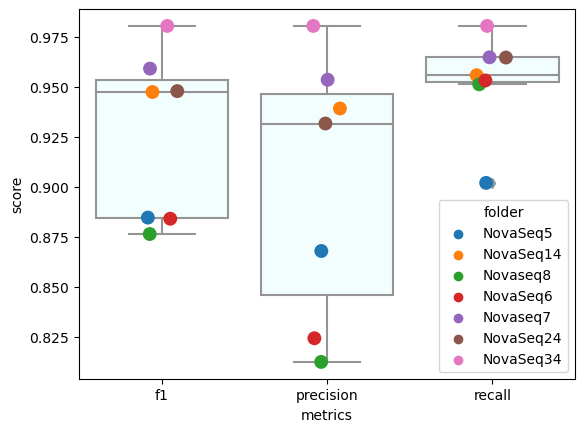

In [33]:
sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10)
sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure')

# Feature importances analysis

In [34]:
data = {'feature_names': X_train_data['joint_meta'].columns}
for mdl in ['ab', 'xgboost', 'rfc']:
    data[mdl] = best_clfs_joint_m[0][mdl]['model'].feature_importances_
fi_df = pd.DataFrame(data)

# Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['xgboost'], ascending=False, inplace=True)
fi_df = fi_df.head(40)
fi_df = fi_df.reset_index(drop=True)

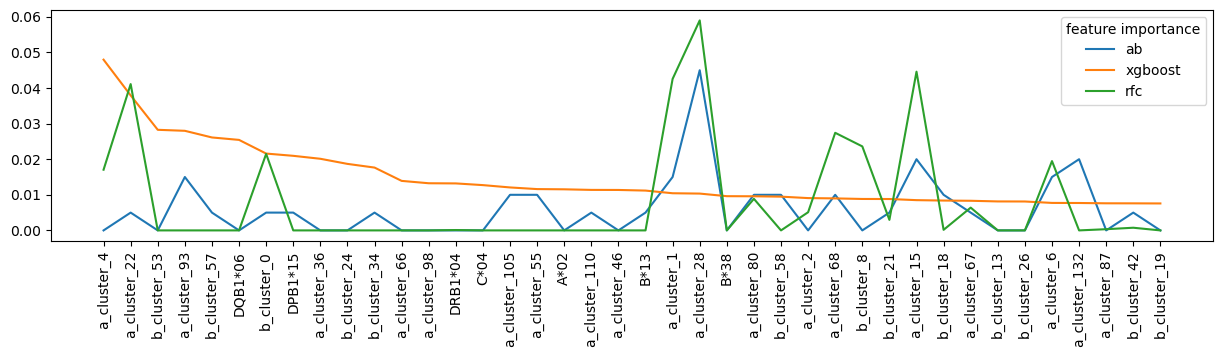

In [35]:
fig, ax = plt.subplots(figsize=(15, 3))
for mdl in ['ab', 'xgboost', 'rfc']:
    ax.plot(fi_df.index, fi_df[mdl], label=mdl)
ax.set_xticks(ticks=range(len(fi_df.index)),
              labels=fi_df.feature_names,
              rotation=90)
ax.legend(title='feature importance')

# Plotting

In [36]:
for key in all_clfs:
    all_clfs[key][0][all_clfs[key][2]].fit(X_train_data[key], y_train_data[key])

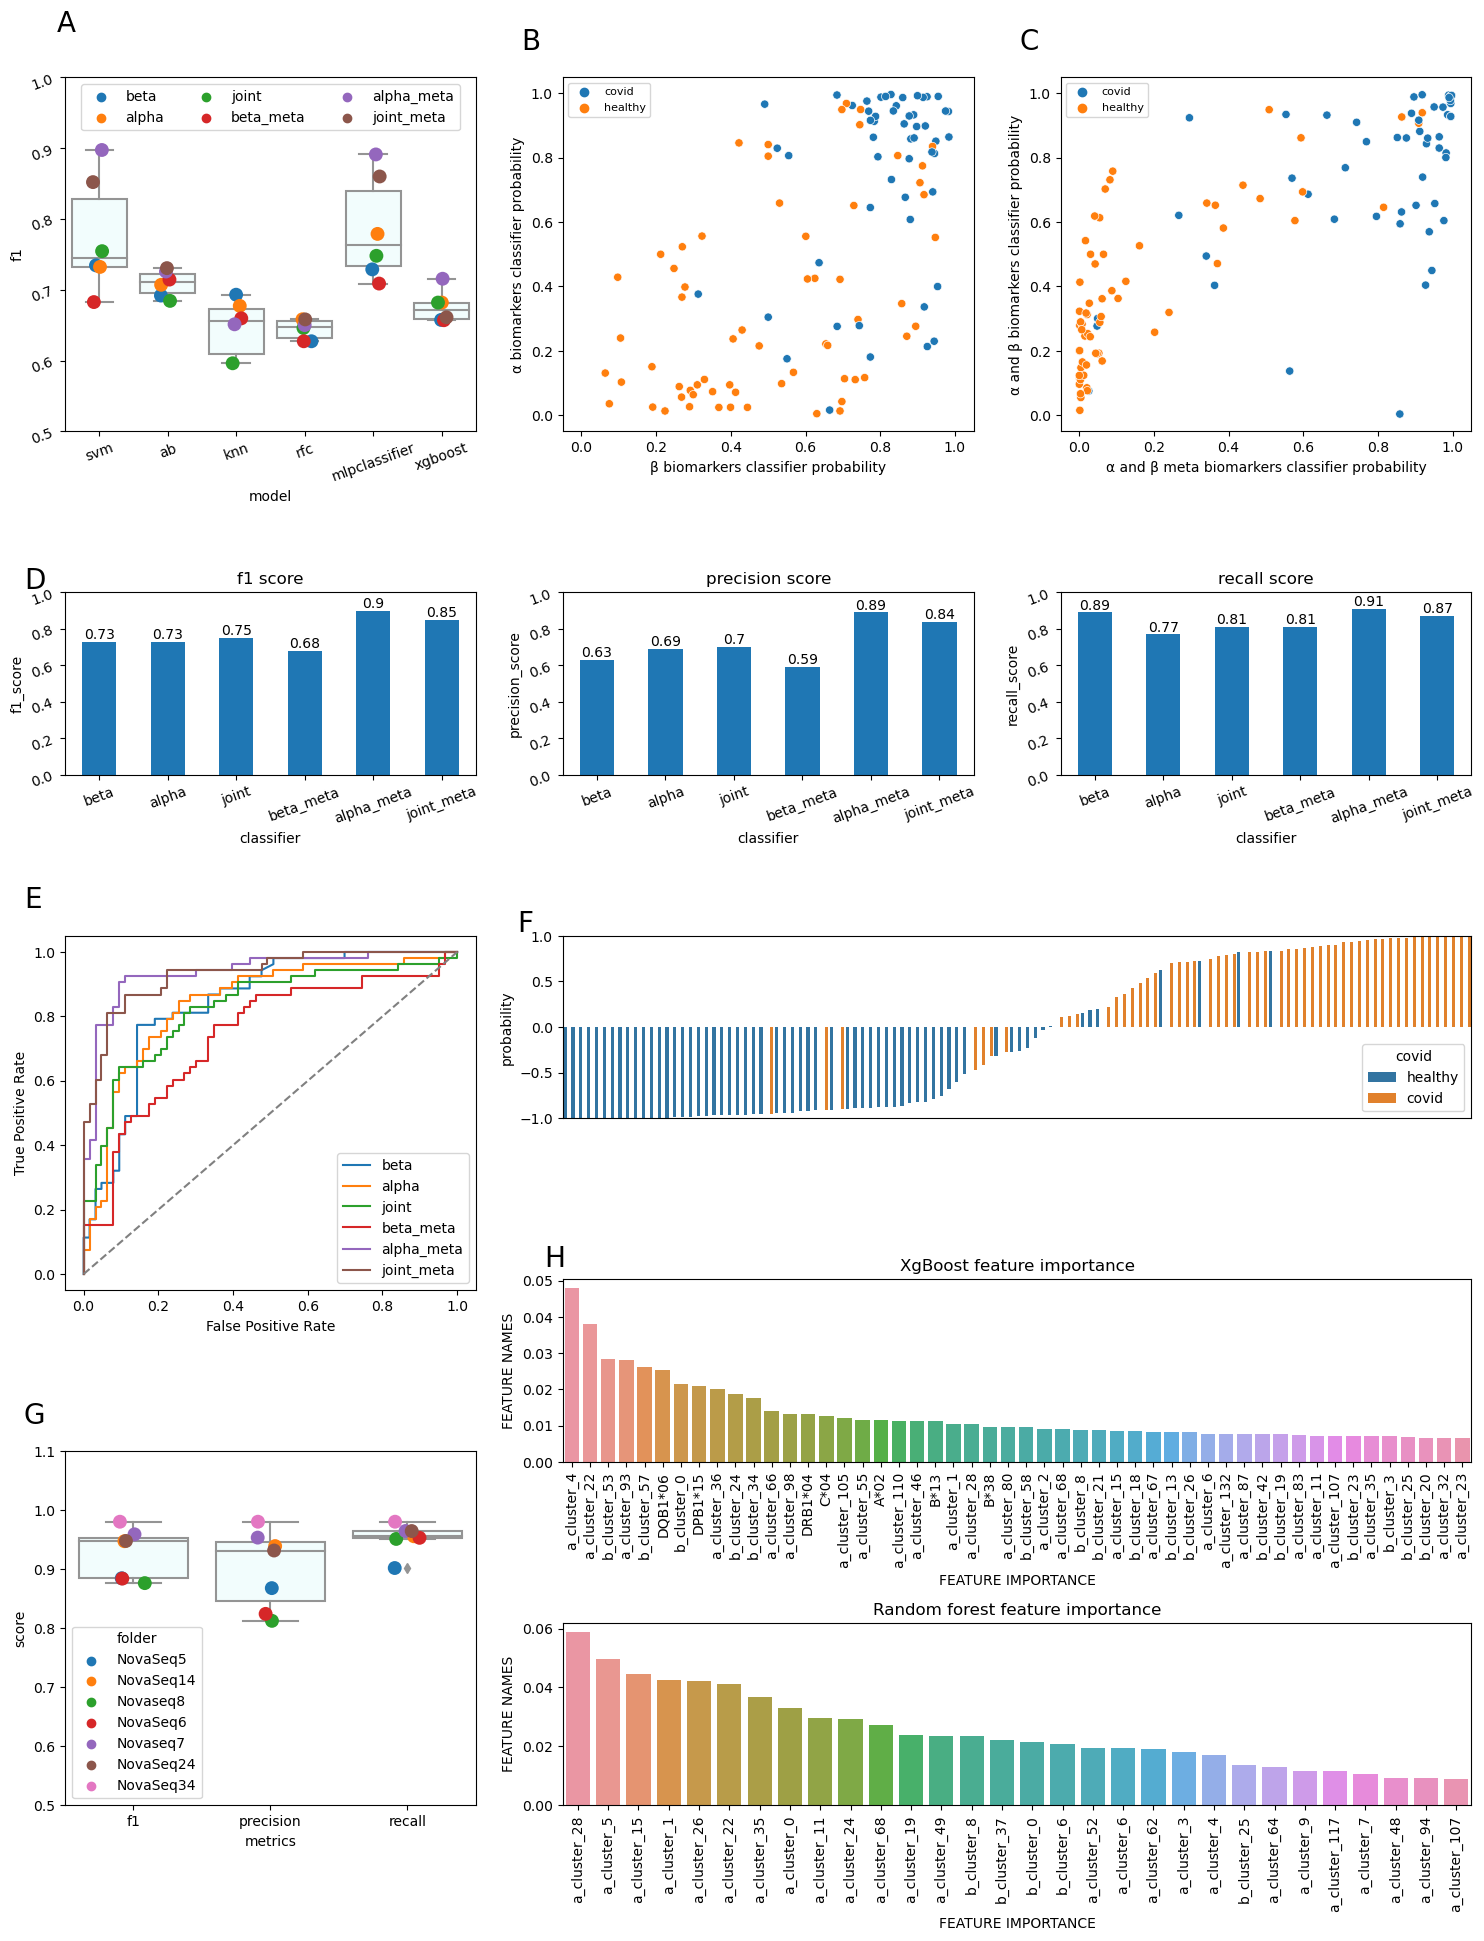

In [37]:
fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=12, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.14


########################################################

for i, (letter, metrics) in enumerate(zip(['D', None, None], ['f1_score', 'precision_score', 'recall_score'])):
    
    ax = fig.add_subplot(gs[3:5, i])
    plotting_df[['classifier', metrics]].set_index('classifier').plot(kind='bar', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.tick_params(labelrotation=20)
    ax.get_legend().remove()
    ax.set_ylabel(metrics)
    ax.set_title(f"{metrics.replace('_', ' ')}")
    ax.tick_params(labelrotation=20)
    ax.set_ylim(0, 1)
    if letter is not None:
        ax.text(delta_x, delta_y, letter,
             horizontalalignment='left',
             verticalalignment='top',
            transform=ax.transAxes,
                size=font_size)

########################################################
ax3 = fig.add_subplot(gs[5:8, 0])

for key in all_clfs:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key][0][all_clfs[key][2]].predict_proba(X_test_data[key])[::,1])
    ax3.plot(fpr,tpr, label=key)

ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax3.legend()
# ax3.set_title('ROC-curve')
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

########################################################

ax4 = fig.add_subplot(gs[:3, 1])
sns.scatterplot(data=probability_df, x='beta_proba', y='alpha_proba', hue='covid')
ax4.legend(fontsize="8", loc ="upper left")
ax4.set_ylim(-0.05, 1.05)
ax4.set_xlim(-0.05, 1.05)
# ax4.set_title('Probability of COVID-19+ for α vs β biomarkers')
ax4.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)
ax4.set_xlabel('β biomarkers classifier probability')
ax4.set_ylabel('α biomarkers classifier probability')

########################################################

ax5 = fig.add_subplot(gs[:3, 2])
sns.scatterplot(data=probability_df, x='joint_meta_proba', y='joint_proba', hue='covid')
ax5.legend(fontsize="8", loc ="upper left")
ax5.set_ylim(-0.05, 1.05)
ax5.set_xlim(-0.05, 1.05)
# ax5.set_title('Probability of COVID-19+ for α and β biomarkers vs meta biomarkers')
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.set_xlabel('α and β meta biomarkers classifier probability')
ax5.set_ylabel('α and β biomarkers classifier probability')


########################################################

ax6 = fig.add_subplot(gs[5:7, 1:])
plot_waterfall_by_column(probability_df, proba_column='joint_meta_proba', label_column='covid', ax=ax6)
# ax6.set_title('Waterfall plot for α+β metaclone classifier')
ax6.text(delta_x+0.05, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.tick_params(bottom=False)
ax6.set_ylim(-1, 1)

########################################################
ax7 = fig.add_subplot(gs[8:11, 0])

sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10, ax=ax7)
sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure', ax=ax7)
# ax7.set_title('Scores across batches for α+β metaclone classifier')
ax7.set_ylim(0.5, 1.1)
ax7.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)
########################################################

ax8 = fig.add_subplot(gs[7:9, 1:])
plot_feature_importances(best_clfs_joint_m[0]['xgboost']['model'],
                         feature_names=X_train_data['joint_meta'].columns, 
                         model_type='xgboost', 
                         k_best=50,
                         ax=ax8)
# for mdl in ['ab', 'xgboost', 'rfc']:
#     ax8.plot(fi_df.index, fi_df[mdl], label=mdl)
# ax8.set_xticks(ticks=range(len(fi_df.index)),
#               labels=fi_df.feature_names,
#               rotation=90)
ax8.text(delta_x+0.08, delta_y+0.05, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax8.transAxes,
        size=font_size)
ax8.set_title('XgBoost feature importance')
########################################################

ax10 = fig.add_subplot(gs[9:11, 1:])
plot_feature_importances(best_clfs_joint_m[0]['rfc']['model'],
                         feature_names=X_train_data['joint_meta'].columns, 
                         model_type='rfc', 
                         k_best=30,
                         ax=ax10)
ax10.set_title('Random forest feature importance')

########################################################

ax9 = fig.add_subplot(gs[:3, 0])
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type", ax=ax9, s=10)
sns.boxplot(data=comparison_df, x="model", y="f1", ax=ax9, color='azure')
ax9.text(delta_x+0.08, delta_y+0.05, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax9.transAxes,
        size=font_size)
# ax9.set_title('Comparison of f1-score across models')
ax9.tick_params(labelrotation=20)
ax9.set_ylim(0.5, 1)
ax9.legend(ncol=3,  loc='upper center')

########################################################

plt.tight_layout()
plt.savefig("figures/fig4.svg")
plt.savefig("figures/fig4.pdf")
plt.savefig("figures/fig4.png")
plt.show()


Figure 4. Analysis of machine learning approaches applied to FMBA TCRβ and TCRα biomarkers. 

A. Distribution of f1-score for all the evaluated models and different types of feature sets.

B. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for TRCα and TCRβ based classifiers.

C. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for classifier based on both TRCα,TCRβ biomarkers and TRCα,TCRβ metaclone cluster features.

D. Distribution of target metrics (f1-score, precision, recall for all the evaluated models.

E. ROC-curve plot for all the evaluated models.

F. The waterfall plot representing the probability of each sample to be labeld as COVID-19 positiove (> 0) or healthy (< 0). Samples coming from healthy donors are colored with blue, COVID-19 samples are colored with orange.

G. Evaluation of target metrics (f1-score, precision, recall) for one batch out cross validation.

H. Feature importance plot for the XGBoost classifier based on TRCα and TCRβ based biomarkers and HLA presence features.